# **Python for Finance -- Session 2 -- Assignment**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>
 
- Copyright (c) Jack Jacquier, 2022. All rights reserved

- Author: Antoine Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.9

In [16]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt

### Let's first compute the reference price

In [20]:
def BSCall(S0, K, sigma, T):
    '''
    #Inputs:
    S0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    #Output:
    Black-Scholes Call price
    '''
    sigT = sigma*np.sqrt(T)
    k = np.log(K/S0)
    dp = -k / sigT + 0.5*sigT
    dm = dp - sigT
    return S0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

In [21]:
S0, K, sigma, T = 100., 100., 0.2, 1.
print("Reference Price: ", BSCall(S0, K, sigma, T))

Reference Price:  7.965567455405798


## Pricing a Call option in Black-Scholes

We will consider the following values for the parameters:
$$
(S_0, K, \sigma, t, T) = (100, 100, 20\%, 0, 1 \text{ year}).
$$


Recall that under the Black-Scholes model, the stock price satisfies at maturity $T$,
\begin{equation*}
S_T
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{n}\sqrt{T}\right\},
\end{equation*}
where $\widetilde{n}$ is a Gaussian random variable. Therefore, for any function $f:\mathbb{R}_+\to\mathbb{R}$, we can write
\begin{equation*}
\mathbb{E}\left[f(S_T)\right] = 
\mathbb{E}\left[f\left(S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{n}\sqrt{T}\right\}\right)\right] =
\int_{\mathbb{R}}f\left(S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma x\sqrt{T}\right\}\right)\phi(x) \mathrm{d} x,
\end{equation*}
where
\begin{equation*}
\phi(x) := \frac{1}{\sqrt{2\pi}}\exp\left\{-\frac{x^2}{2}\right\}
\end{equation*}
is the Gaussian density.


Write a Python function pricing a Call option in the Black-Scholes model by integration. 
Check that with the parameters above you obtain a Call option price equal to $7.965567455405798$.

In [22]:
from scipy.integrate import quad, simps
def integrand(x, S0, K, sigma, T):
    gaussianDensity = np.exp(-.5*x*x) / np.sqrt(2.*np.pi)
    payoffFunction = np.maximum(S0*np.exp((-.5*sigma*sigma*T + sigma*np.sqrt(T)*x))-K, 0.)
    return payoffFunction*gaussianDensity

In [23]:
print('Black-Scholes Call price by integration:')
xMin, xMax = -5., 5.
qf = quad(integrand, xMin, xMax, args=(S0, K, sigma, T,))
xx = np.linspace(xMin, xMax, 1000)
qs = simps([integrand(x, S0, K, sigma, T) for x in xx], xx)
print("Quadrature: ", qf)
print("Simpson: ", qs)
print("***************************")

Black-Scholes Call price by integration:
Quadrature:  (7.9655167877012145, 7.187613810377482e-08)
Simpson:  7.965548568013442
***************************


### Pricing by simulation

Using the representation
\begin{equation*}
S_T
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma W_T\right\}
 = S_0\exp\left\{-\frac{\sigma^2 T}{2} + \sigma\widetilde{n}\sqrt{T}\right\} \text{ (in distribution)},
\end{equation*}
and the approximation
$$
\mathbb{E}[f(S_T)] \approx \frac{1}{N}\sum_{i=1}^{N}f\left(S_T^{(i)}\right),
$$
for any continuous function $f$, where $(S_T^{(i)})_{i=1,\ldots,N}$ are independent random copies of $S_T$, write a Python function for a Call option price. With the same parameters as in 2.1, plot the convergence of the Call price as a function of $N$.

**Remark:** Note that here, you do not in fact need to simulate trajectories of the Brownian motion since the option is *European*, i.e. only depends on the value of the underlying stock price at maturity. For path-dependent options, however, simulations of the paths are required.

In [24]:
def bsSimulation(S0, K, T, sigma, n):
    nn = np.random.normal(0., 1., (n))
    S = S0*np.exp((-.5*sigma*sigma*T + sigma*np.sqrt(T)*nn))
    f = np.maximum(S-K, 0.)
    return np.mean(f)

In [25]:
nn = np.arange(500, 100000, 1000)

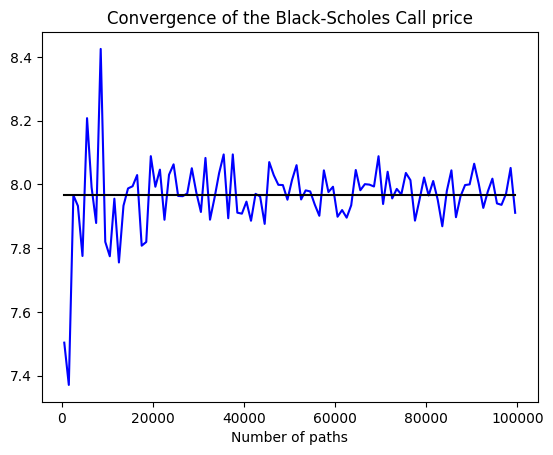

In [26]:
bb = [bsSimulation(S0, K, T, sigma, n) for n in nn]
trueBS = [BSCall(S0, K, sigma, T)]*len(nn)
plt.plot(nn, bb, 'b')
plt.plot(nn, trueBS, 'k')
plt.title("Convergence of the Black-Scholes Call price")
plt.xlabel("Number of paths")
plt.show()

## Implied volatility

Recall that in the Black-Scholes model (without interest rates), the value of a European Call option on $(S_t)_{t\geq 0}$ is given at inception by
$$
C^{\mathrm{BS}}(S_0, K, T;\sigma) = S_0\left(\mathcal{N}(d_{+}) - \mathrm{e}^{k}\mathcal{N}(d_{-})\right),
$$
where
$$
d_{\pm} = \frac{-k}{\sigma\sqrt{T}} \pm\frac{\sigma\sqrt{T}}{2}
\quad \text{ and } \quad k := \log\left(\frac{K}{S_0}\right),
$$
and where $\mathcal{N}$ denotes the Gaussian cumulative distribution function.


- For any fixed $k\in\mathbb{R}$, $T, S_0>0$, show that the map $\sigma\mapsto C^{\mathrm{BS}}(S_0, K, T;\sigma)$ is bijective;
- Compute 
$$
\lim_{\sigma\downarrow 0}C^{\mathrm{BS}}(S_0, K, T;\sigma)
$$
and 
$$
\lim_{\sigma\uparrow\infty}C^{\mathrm{BS}}(S_0, K, T;\sigma).
$$

### Solution: Since by arbitrage conditions we have $$(S_0-K)^+\leq C^{BS}(S_0, K, T;\sigma) \leq S_0 $$

### This gives an upper and lower bound for the options price. Moreover we know that $$\frac{\partial C^{BS}(S_0, K, T;\sigma)}{d \sigma}>0$$ meaning that $C^{BS}$ is monotonically increasing in $\sigma\in\mathbb{R}^+$.

### Therefore, we must have $$ \lim_{\sigma\downarrow 0}C^{\mathrm{BS}}(S_0, K, T;\sigma) =(S_0-K)^+$$ and $$\lim_{\sigma\uparrow\infty}C^{\mathrm{BS}}(S_0, K, T;\sigma)=S_0 $$

e.g. the limits hit the arbitrage-free bounds on both ends

- Write a Python function with inputs $S_0, K, T, C$ that returns the implied volatility, solution to the equation $C^{\mathrm{BS}}(S_0, K, T;\sigma) = C$.
*Hint: You can either use a root-finding method using the bijective property, or try to minimise the squared difference*.
- Verify that the implied volatility corresponding to $(S_0, K, T, C) = (100., 100., 1., 7.9655674)$ is equal to $20\%$.

In [43]:
from scipy.optimize import fsolve, root, minimize

def f(sigma, *args):
    S0, K, T, optionPrice = args ## optional arguments, where optionPrice is the Call option price to match
    return (BSCall(S0, K, sigma, T)-optionPrice) ## define the objective equation to solve 

def f_squared(sigma, *args):
    S0, K, T, optionPrice = args ## optional arguments, where optionPrice is the Call option price to match
    return (BSCall(S0, K, sigma, T)-optionPrice)**2
optionPrice = 3.9

#Option 1) fsolve
impliedVol = fsolve(f, x0=0.3, args=((S0, K, T, optionPrice, )))[0]


### Verification that Black-Scholes(implied volatility) = optionPrice
print("Verification error: ", optionPrice - BSCall(S0, K, impliedVol, T))

#Option 2) root
impliedVol = root(f, x0=0.3, args=((S0, K, T, optionPrice, ))).x


### Verification that Black-Scholes(implied volatility) = optionPrice
print("Verification error: ", optionPrice - BSCall(S0, K, impliedVol, T))

#Option 3) minimize
impliedVol = minimize(f_squared, x0=0.3, args=((S0, K, T, optionPrice, ))).x 
###Since minimize, looks for the minimum value, we need to squre the different to prevent
### otherwise the algorithm won't work


### Verification that Black-Scholes(implied volatility) = optionPrice
print("Verification error: ", optionPrice - BSCall(S0, K, impliedVol, T))

Verification error:  -9.325873406851315e-15
Verification error:  [-9.32587341e-15]
Verification error:  [9.38911911e-07]


## Discrete versus continuous compounding¶

Suppose that you invest $\Pi$ GBP today in a risk-free bank account.
Considering compound interest rate yields the amount if one is earning  is
\begin{equation*}
\Pi\left(1+\frac{r}{n}\right)^{nT}.
\end{equation*}
over the period $[0,T]$, where $r$ is the annual nominal interest rate and $n$ the number of times the interest is compounded per year.
For example, if $n=1$, this is a yearly rate, for $n=2$, this is a 6-month rate, and $n=252$ corresponds to a daily rate.

**Question:** 
- Write a program computing  how much money will be compounded as a function of $\Pi, r, n, T$.
- As $n$ becomes large, compute the limit of Equation (1), and illustrate it numerically.

Available data:
- Annual rates provided by the Bank of England are available here: https://www.bankofengland.co.uk/boeapps/database/Bank-Rate.asp

- Annual rates by Bank of China can be found here: https://www.global-rates.com/en/interest-rates/central-banks/central-bank-china/pbc-interest-rate.aspx

In [28]:
def returns(P, r, T, n):
    return P*(1.+r/n)**(n*T)

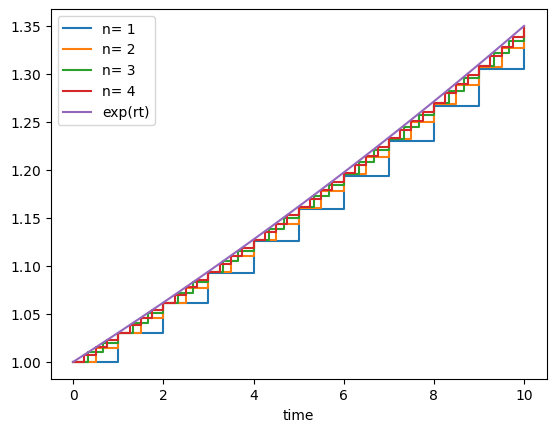

In [29]:
P0, r, T = 1, .03, 10.
nn = range(1, 5)

for n in nn:
    step = 1./float(n)
    t = 0.
    tt, pp = [], []
    for i in range(1, 1+int(n*T)):
        t = i*step
        tminus = t-step
        pminus = P0*(1.+r/n)**(n*(tminus))
        P = returns(P0, r, t, n)
        tt.extend((tminus, t, t))
        pp.extend((pminus, pminus, P))
    plt.plot(tt, pp, label='n= %d' %n)
plt.plot(tt, [P0*np.exp(r*t) for t in tt], label='exp(rt)')
plt.xlabel("time")
plt.legend(loc="best")
plt.show()